# Final Notebook 001 - Data Acquisition and Descriptive Statistics

## Import

In [1]:
import sentisignal
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np 
import pylab as P 
import ast
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import scipy.stats as s
import statsmodels.api as sm
import pprint
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from datetime import datetime
from yahoo_finance import Share
from pandas_datareader import data, wb
from statsmodels.graphics.api import qqplot
from operator import itemgetter
from decimal import *

# plt.style.use('ggplot')
# sns.set_style("darkgrid")
# sns.set_context("notebook")

## Configuration

In [3]:
data_primary_path = '../../data/csv/stocktwits_twitter_withretweets_daily.csv'
data_symbology_path = '../../data/csv/symbology.csv'
data_pickles_path = '../../data/pickles/'
data_nasdaq_company_list_path = '../../data/nasdaq/companylist.csv'
start_date = '2012-01-01'
end_date = '2012-01-07'

In [4]:
plot_width = 8
plot_height = 8

## NASDAQ Data

In [5]:
data_symbology = pd.read_csv(data_symbology_path)

### Use NASDAQ data to get top 100 companies by MarketCap

In [6]:
data_nasdaq_company_list = pd.read_csv(data_nasdaq_company_list_path)
data_nasdaq_top_100_mkt_cap = data_nasdaq_company_list.head(100)
data_nasdaq_top_100_mkt_cap_symbols = data_nasdaq_top_100_mkt_cap['Symbol'].unique()

### Calculate breakdown per sector (using PsychSignal symbology)

(-1.0128662320463357, 1.0, -1.0193658825849057, 1.0141629122482432)

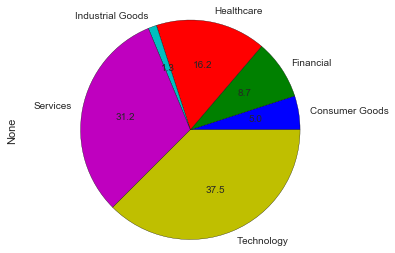

In [121]:
data_nasdaq_top_100_mkt_cap_symbology = pd.merge(data_nasdaq_top_100_mkt_cap, data_symbology, left_on='Symbol', right_on='symbol', how = "left")
data_nasdaq_top_100_mkt_cap_symbology_sector_size = data_nasdaq_top_100_mkt_cap_symbology.groupby(['sector']).size()
data_nasdaq_top_100_mkt_cap_symbology_sector_size.plot(kind='pie', autopct='%.1f')
plt.axis('equal')

### Calculate and graph yearly mean of average monthly messages

In [9]:
sum_avg_cols = [col for col in data_nasdaq_top_100_mkt_cap_symbology.columns if ('all_scanned_20' in col and 'avg_monthly' in col)]
data_nasdaq_top_100_mkt_cap_symbology['mean_avg_monthly'] = data_nasdaq_top_100_mkt_cap_symbology[sum_avg_cols].sum(axis=1)/len(sum_avg_cols)

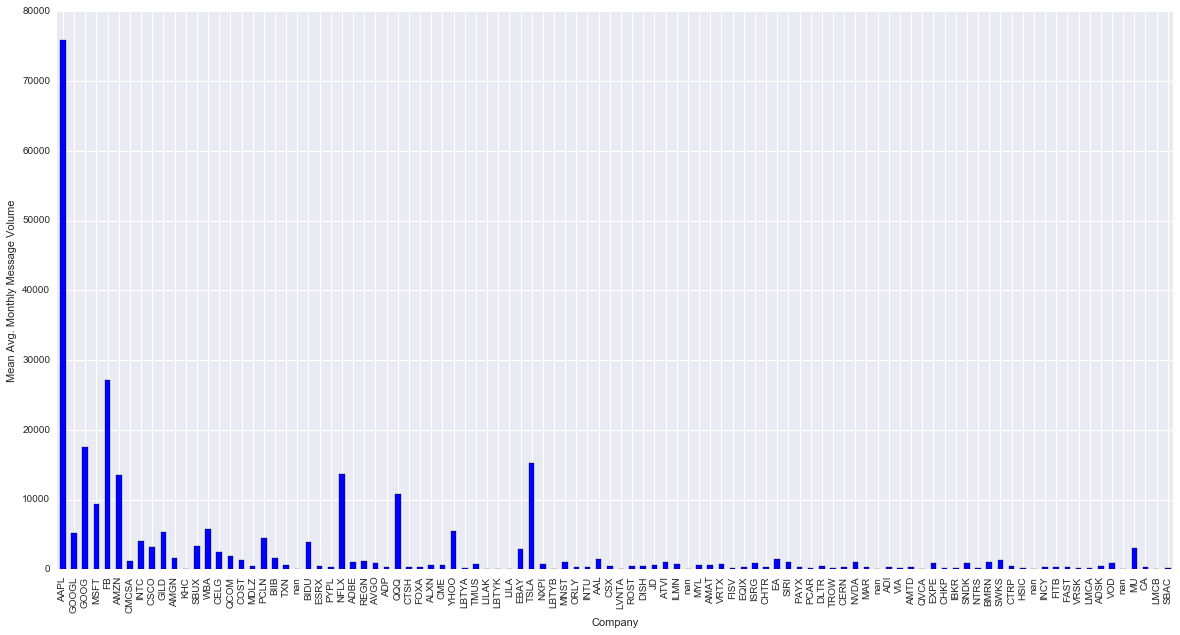

In [10]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
data_nasdaq_top_100_mkt_cap_symbology['mean_avg_monthly'].plot(kind='bar')
ax.set_xticklabels(data_nasdaq_top_100_mkt_cap_symbology['symbol'], rotation=90)
plt.ylabel('Mean Avg. Monthly Message Volume')
plt.xlabel('Company')
plt.show()

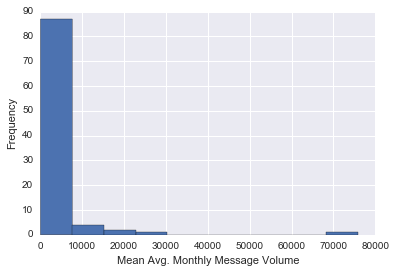

In [11]:
data_nasdaq_top_100_mkt_cap_symbology.hist(column=['mean_avg_monthly'])
plt.ylabel('Frequency')
plt.xlabel('Mean Avg. Monthly Message Volume')
plt.title('')

### Correlation matrix

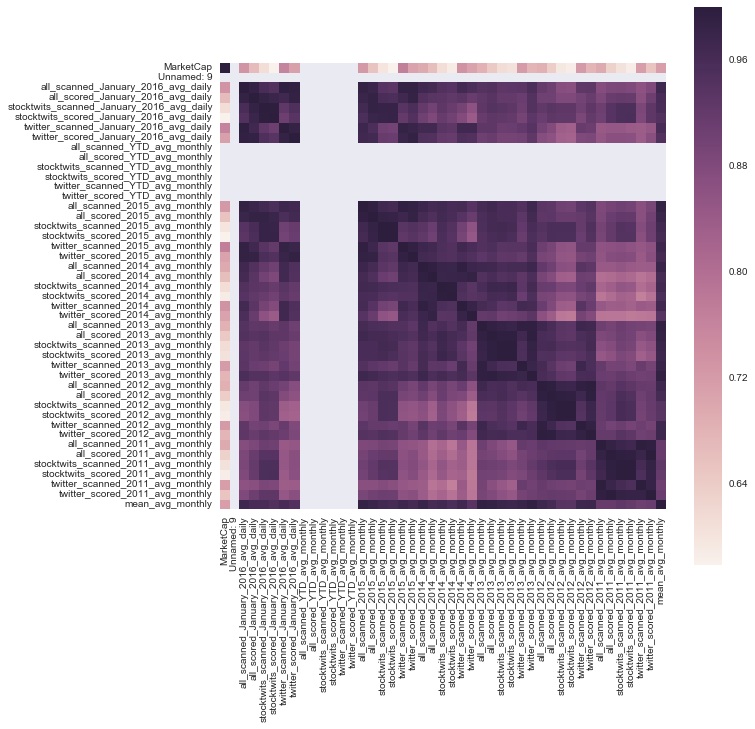

In [12]:
sentisignal.plot_corr(data_nasdaq_top_100_mkt_cap_symbology)

### MarketCap and mean_avg_monthly regression

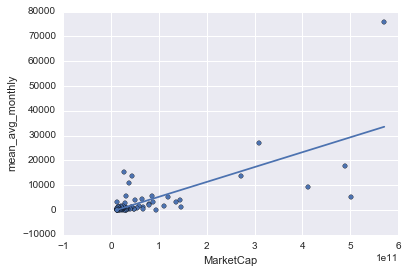

In [116]:
sentisignal.plot_scatter_regression(data_nasdaq_top_100_mkt_cap_symbology, 'MarketCap', 'mean_avg_monthly')

## Subsample sentiment data (Daily Stocktwits and Twitter with retweets)

In [84]:
data_nasdaq_top_100_sentiment = sentisignal.subsample_data(data_primary_path, data_symbology_path, data_pickles_path, start_date, end_date, 'SYMBOL', data_nasdaq_top_100_mkt_cap_symbols, False)

Loaded from pre-created pickle


## Scrape finance data (Yahoo! Finance)

In [123]:
data_nasdaq_top_100_finance = sentisignal.get_data_finance('google', data_nasdaq_top_100_mkt_cap_symbols, start_date, end_date, data_pickles_path, False, 'NaN')

Scraping and saving data from google
AAPL
GOOGL
GOOG
MSFT
FB
AMZN
CMCSA
INTC
CSCO
GILD
AMGN
KHC
SBUX
WBA
CELG
QCOM
COST
MDLZ
PCLN
BIIB
TXN
FOX
BIDU
ESRX
PYPL
NFLX
ADBE
REGN
AVGO
ADP
QQQ
CTSH
FOXA
ALXN
CME
YHOO
LBTYA
TMUS
LILAK
LBTYK
LILA
EBAY
TSLA
NXPI
LBTYB
MNST
ORLY
INTU
AAL
CSX
LVNTA
ROST
DISH
JD
ATVI
ILMN
LVNTB
MYL
AMAT
VRTX
FISV
EQIX
ISRG
CHTR
EA
SIRI
PAYX
PCAR
DLTR
TROW
CERN
NVDA
MAR
QVCB
ADI
VIA
AMTD
QVCA
EXPE
CHKP
IBKR
SNDK
NTRS
BMRN
SWKS
CTRP
HSIC
VIAB
INCY
FITB
FAST
VRSK
LMCA
ADSK
VOD
LMCK
MU
CA
LMCB
SBAC


### Preprocess and merge

In [128]:
# preprocess creating additional statistics 
[data_nasdaq_top_100_sentiment_preprocessed, data_nasdaq_top_100_finance_preprocessed] = sentisignal.preprocess_per_symbol(data_nasdaq_top_100_sentiment, data_nasdaq_top_100_finance)

In [129]:
data_nasdaq_top_100_preprocessed_merge = sentisignal.merge_sentiment_finance(data_nasdaq_top_100_sentiment_preprocessed, data_nasdaq_top_100_finance_preprocessed, True, True, True)

### Describe

In [130]:
data_nasdaq_top_100_preprocessed_merge.describe()

,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,BULL_BEAR_MSG_RATIO,TOTAL_SCANNED_MESSAGES,LOG_BULL_RETURN,LOG_BEAR_RETURN,LOG_BULLISHNESS,...,PCA_SENTIMENT,OPEN,HIGH,LOW,CLOSE,VOLUME,LOG_RETURN,VOLATILITY,LOG_VOLUME_DIFF,PCA_FINANCE
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,...,256.000000,256.000000,256.000000,256.000000,256.000000,2.560000e+02,256.000000,256.000000,256.000000,256.000000
mean,1.262344,0.988242,0.274102,14.847656,6.722656,1.533164,69.554688,0.198251,0.139196,0.500216,...,25.260640,106.522383,108.028906,105.413672,107.074844,1.095449e+07,0.003997,2.615234,4.351134,9626.184571
std,0.940656,0.998566,1.278983,42.073281,21.328919,3.147769,201.484172,1.015896,0.900000,0.921413,...,127.783778,313.252345,318.175893,310.287765,315.130735,1.851285e+07,0.017456,8.292056,6.493791,5224999.389584
min,0.000000,0.000000,-3.100000,0.000000,0.000000,0.000000,1.000000,-1.945910,-2.302585,-2.302585,...,-417.702927,0.000000,0.000000,0.000000,2.950000,0.000000e+00,-0.048579,-3.100000,0.000000,-43010357.250000
25%,0.000000,0.000000,-0.365000,0.000000,0.000000,0.000000,4.000000,-0.409597,-0.239278,0.000000,...,-4.432645,22.372500,22.857500,22.177500,22.655000,1.296102e+06,-0.002726,0.477500,0.000000,-689728.000036
50%,1.565000,1.015000,0.000000,2.000000,1.000000,0.000000,10.500000,0.000000,0.000000,0.690162,...,1.318629,32.235000,32.915000,32.100000,32.215000,3.580888e+06,0.000000,0.770000,0.000000,-28139.251288
75%,2.027500,1.900000,1.200000,9.250000,4.000000,2.000000,34.000000,0.693147,0.556406,1.098612,...,11.465509,57.670000,58.225000,57.430000,57.747500,1.026177e+07,0.010149,1.442500,12.417085,489933.062501
max,3.040000,3.100000,3.040000,413.000000,164.000000,21.000000,1862.000000,3.135494,3.367296,3.332205,...,1030.254755,2491.500000,2514.500000,2453.500000,2497.000000,1.005531e+08,0.107393,92.940000,18.082878,28323254.750002


### Correlation matrix

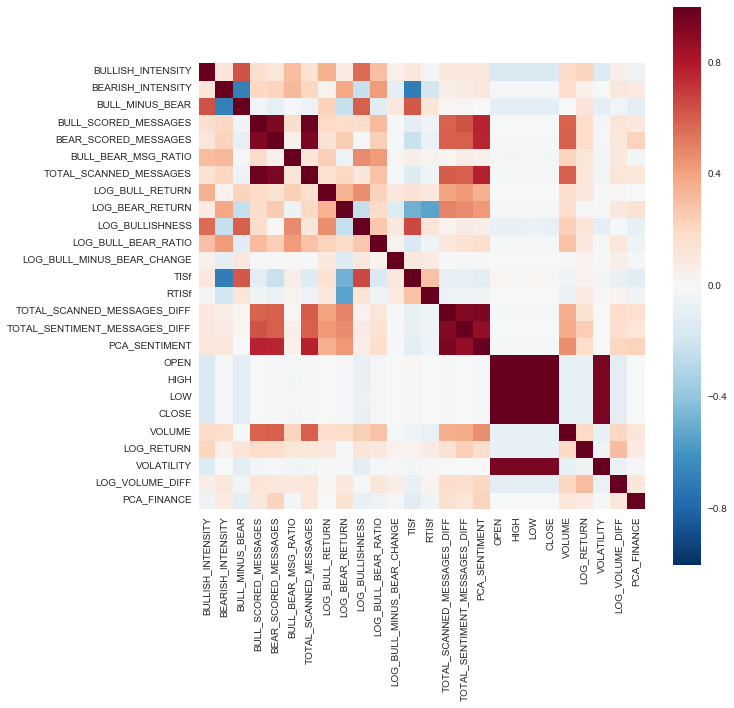

In [131]:
sentisignal.plot_corr(data_nasdaq_top_100_preprocessed_merge)

### Clustermap

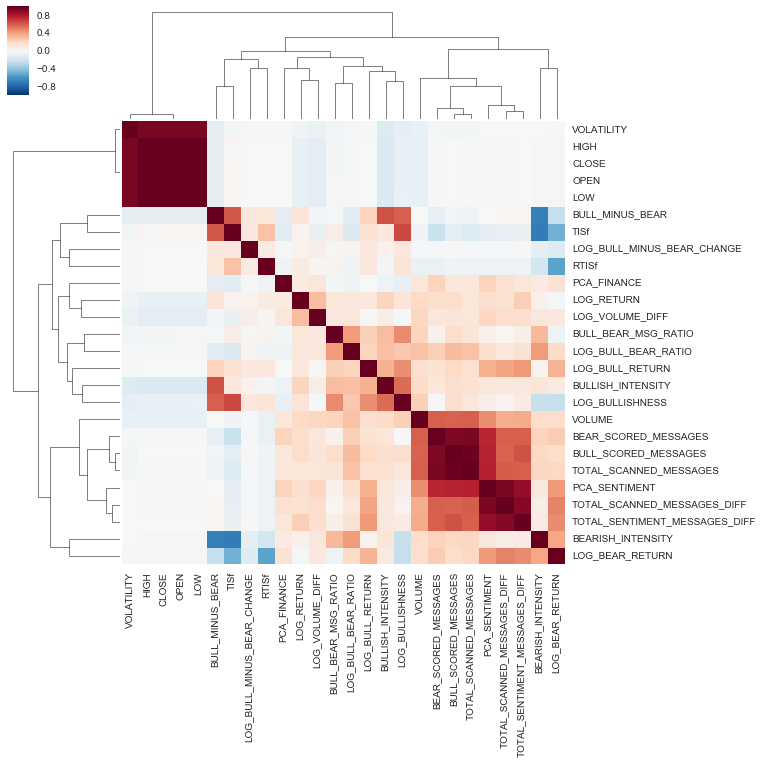

In [132]:
sentisignal.plot_clustermap(data_nasdaq_top_100_preprocessed_merge)


### PDF

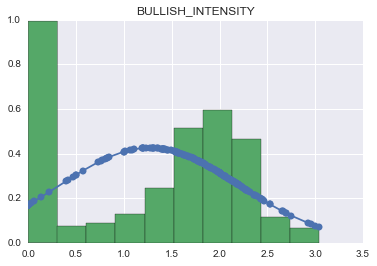

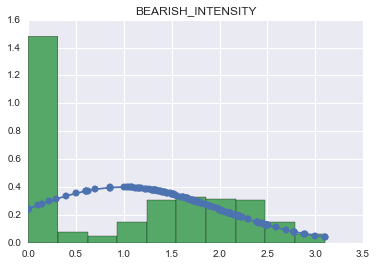

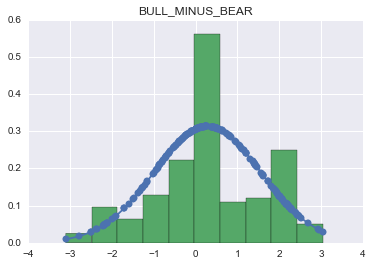

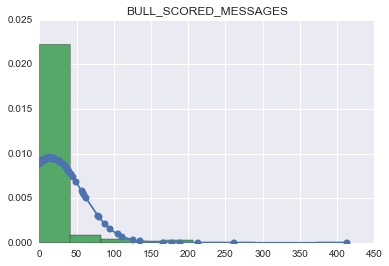

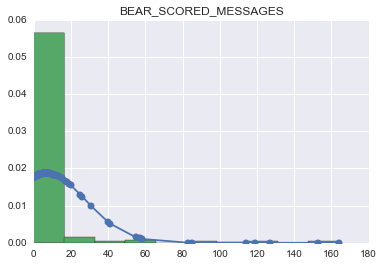

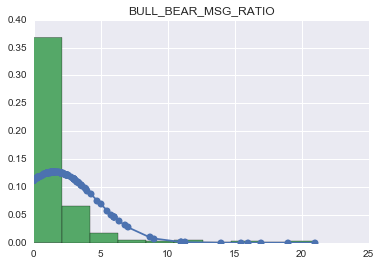

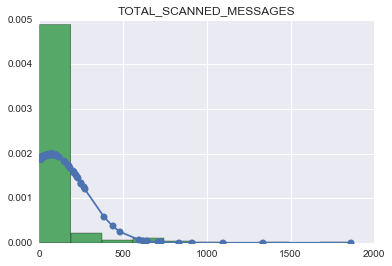

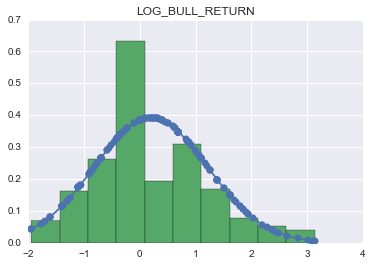

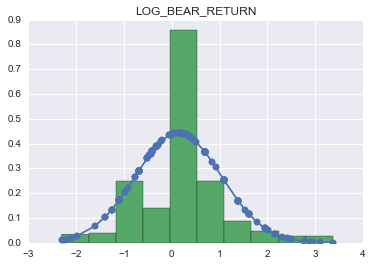

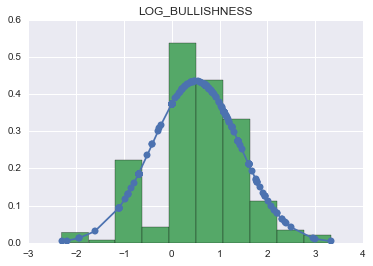

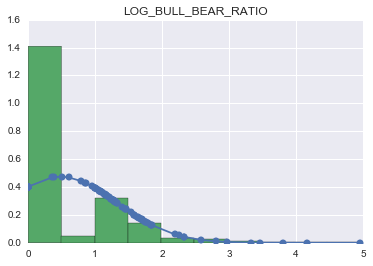

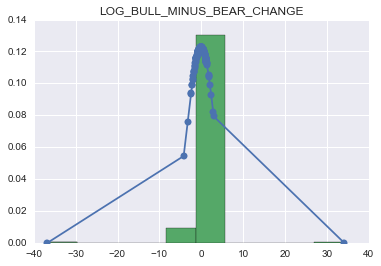

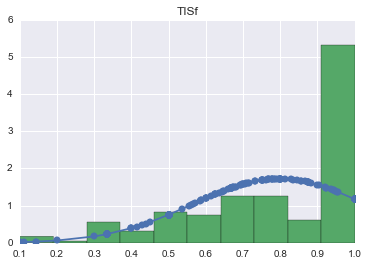

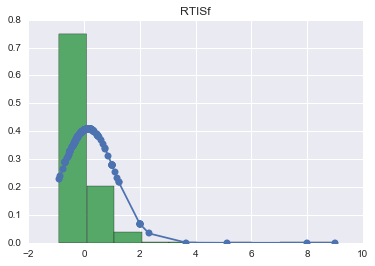

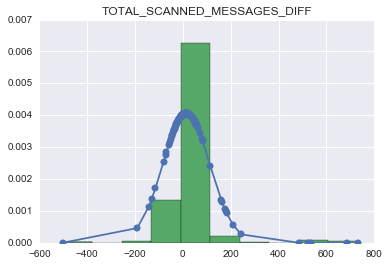

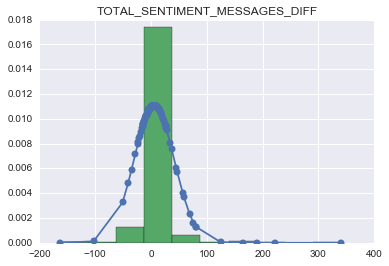

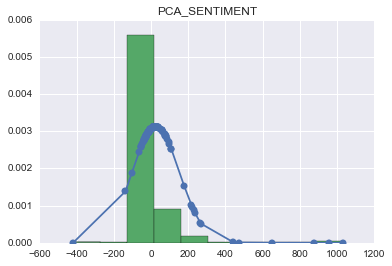

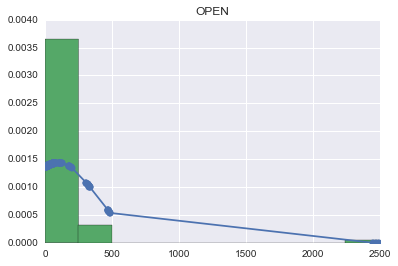

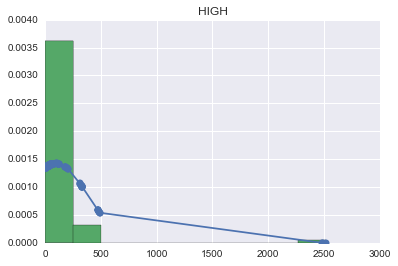

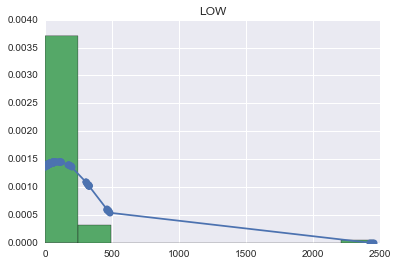

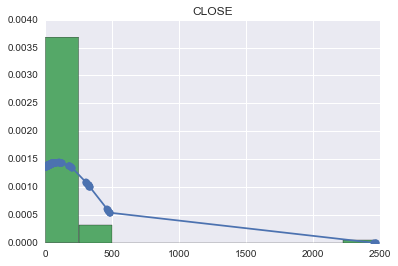

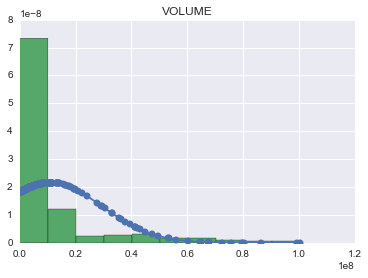

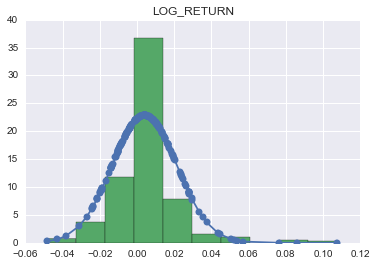

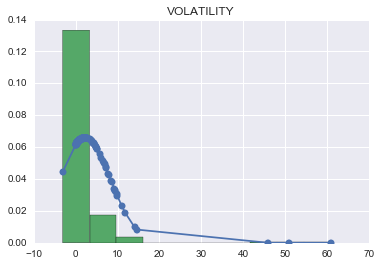

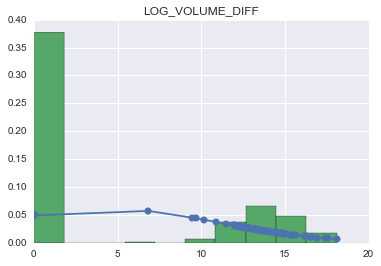

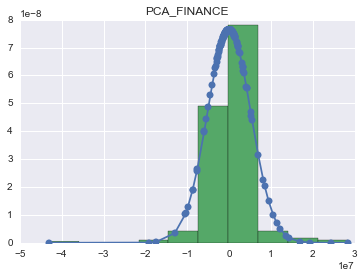

In [133]:
sentisignal.check_pdf(data_nasdaq_top_100_preprocessed_merge)

### ACF

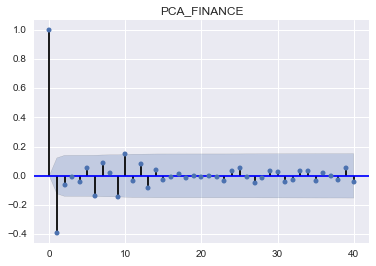

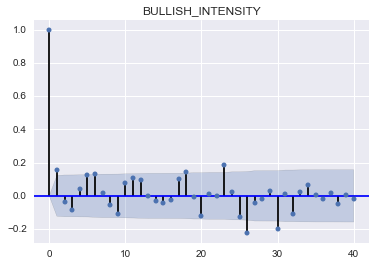

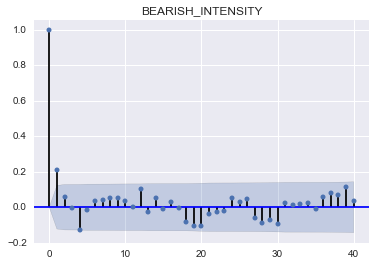

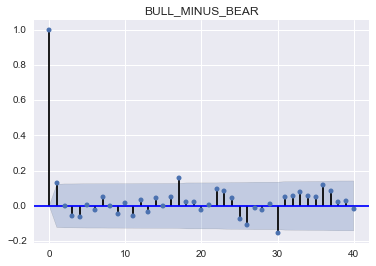

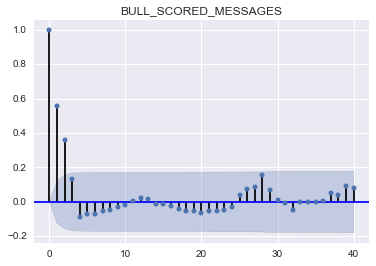

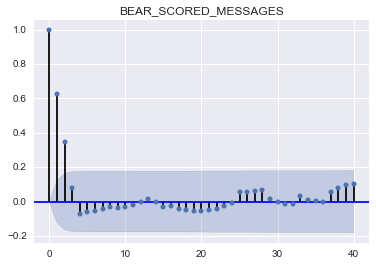

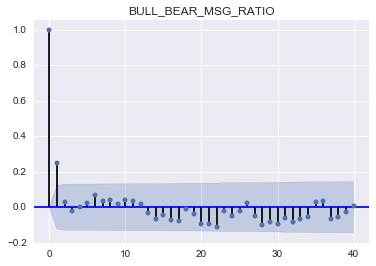

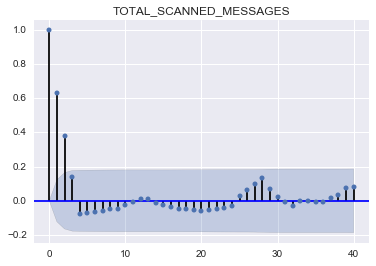

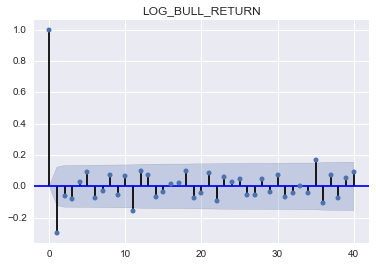

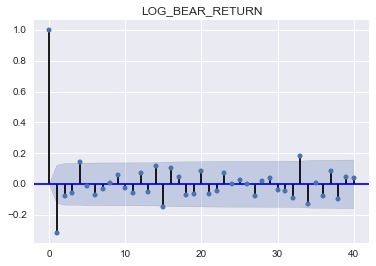

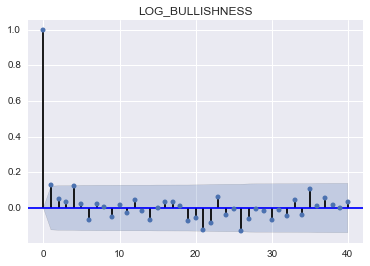

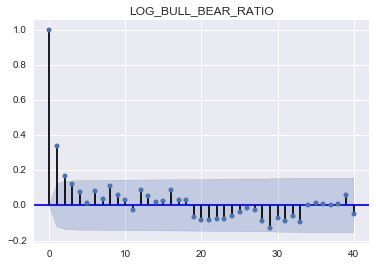

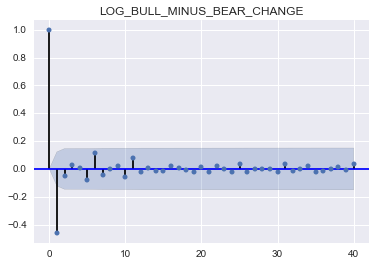

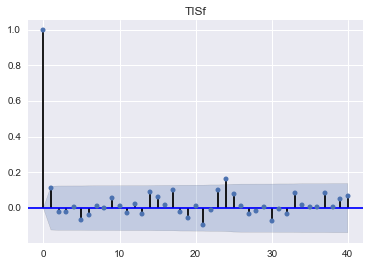

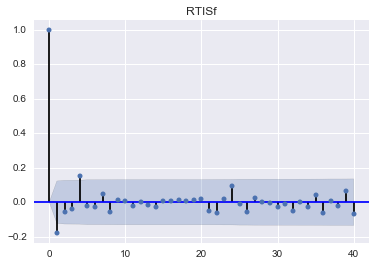

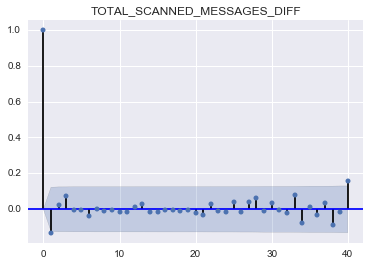

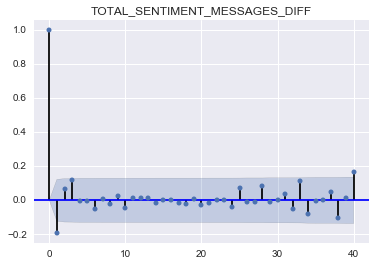

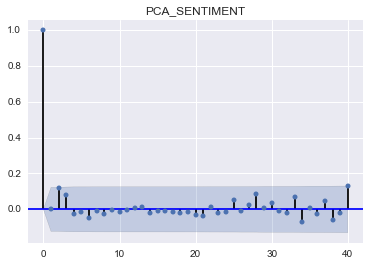

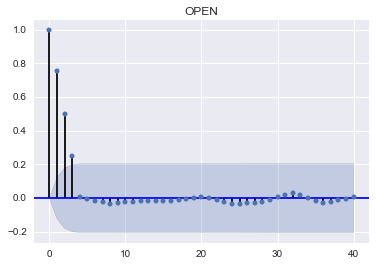

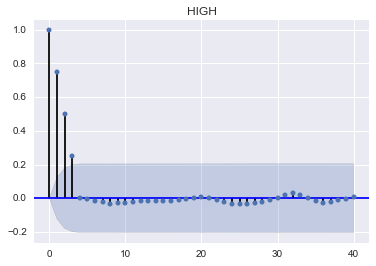

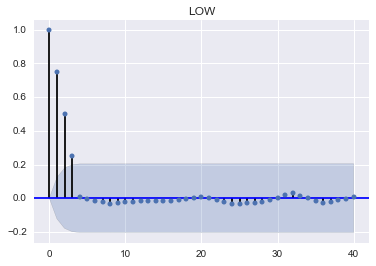

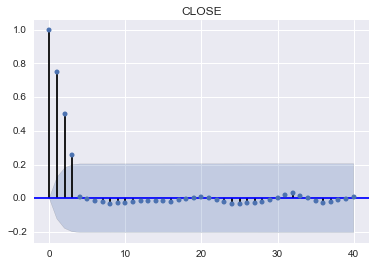

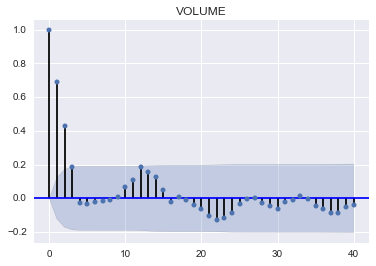

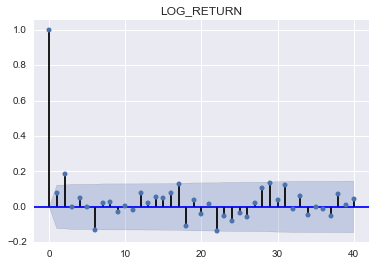

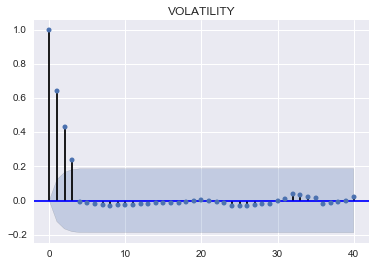

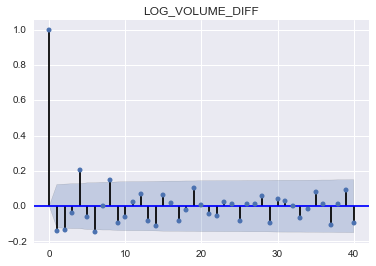

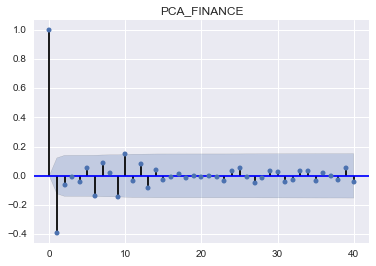

In [134]:
sentisignal.check_acf(data_nasdaq_top_100_preprocessed_merge)

### Regression between PCA (Sentiment) and PCA (Finance)

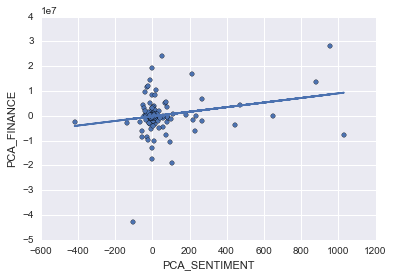

In [135]:
sentisignal.plot_scatter_regression(data_nasdaq_top_100_preprocessed_merge, 'PCA_SENTIMENT', 'PCA_FINANCE')

### Save results to intermediate pickle

In [136]:
data_nasdaq_top_100_preprocessed_merge.to_pickle(data_pickles_path+'intermediate/'+'data_nasdaq_top_100_preprocessed_merge_'+start_date+'_'+end_date)

## Apply rolling window and repeat analysis

In [137]:
data_nasdaq_top_100_preprocessed_merge_window_30 = sentisignal.split_apply_combine(data_nasdaq_top_100_preprocessed_merge, 'SYMBOL', sentisignal.apply_rolling_window, (30))

### Describe

In [138]:
data_nasdaq_top_100_preprocessed_merge_window_30.describe()

,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,BULL_BEAR_MSG_RATIO,TOTAL_SCANNED_MESSAGES,LOG_BULL_RETURN,LOG_BEAR_RETURN,LOG_BULLISHNESS,...,PCA_SENTIMENT,OPEN,HIGH,LOW,CLOSE,VOLUME,LOG_RETURN,VOLATILITY,LOG_VOLUME_DIFF,PCA_FINANCE
count,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,2.550000e+02,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,2.550000e+02
mean,1.295781,0.950788,0.344993,13.759150,6.287255,1.365801,65.553268,0.389412,0.336049,0.519988,...,3.152816e+01,97.495791,98.671408,96.362088,97.613059,11001081.409477,0.001944,2.309320,2.976196,-6.572744e+05
std,0.745806,0.813063,0.975523,33.366107,17.316059,2.209156,169.707095,0.689963,0.570591,0.787202,...,8.853462e+01,279.308761,281.755509,275.448977,277.957691,17349116.366360,0.009506,6.350857,3.327112,3.160848e+06
min,0.000000,0.000000,-2.490000,0.000000,0.000000,0.000000,1.000000,-0.804719,-1.098612,-1.945910,...,-1.032867e+02,0.000000,0.000000,0.000000,2.950000,0.000000,-0.024289,-0.900000,0.000000,-4.301036e+07
25%,0.736667,0.000000,-0.211667,1.000000,0.000000,0.000000,5.416667,0.000000,0.000000,0.000000,...,4.163336e-16,22.025833,22.556667,21.903333,22.418333,1336412.500000,-0.001117,0.524167,0.000000,-5.756550e+05
50%,1.485000,0.970000,0.083333,2.500000,1.000000,0.500000,10.000000,0.231049,0.173287,0.462098,...,3.382896e+00,32.763333,33.290000,32.125000,32.215000,3613567.666667,0.000000,0.805000,3.045474,-8.117517e+04
75%,1.887500,1.548333,0.971250,9.583333,3.708333,2.020000,35.500000,0.654757,0.549306,0.960607,...,1.611682e+01,57.178333,57.975000,56.863750,57.279583,10988938.000000,0.005496,1.530000,5.114478,5.820766e-11
max,3.040000,2.780000,3.040000,260.250000,123.750000,16.000000,1301.250000,3.135494,2.772589,3.332205,...,6.477397e+02,2491.500000,2514.500000,2453.500000,2471.500000,75564699.000000,0.053697,61.000000,12.796675,5.729237e+06


### Correlation matrix

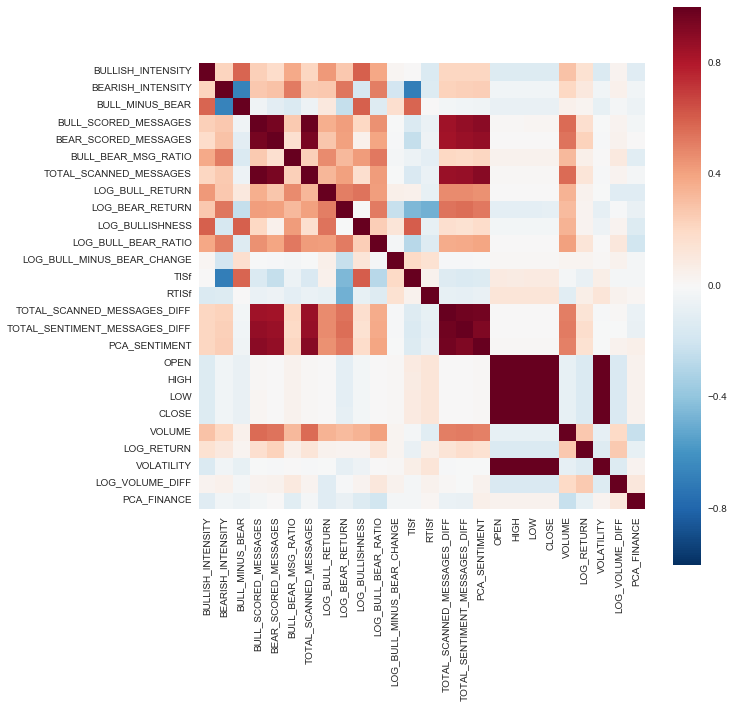

In [139]:
sentisignal.plot_corr(data_nasdaq_top_100_preprocessed_merge_window_30)

### Clustermap

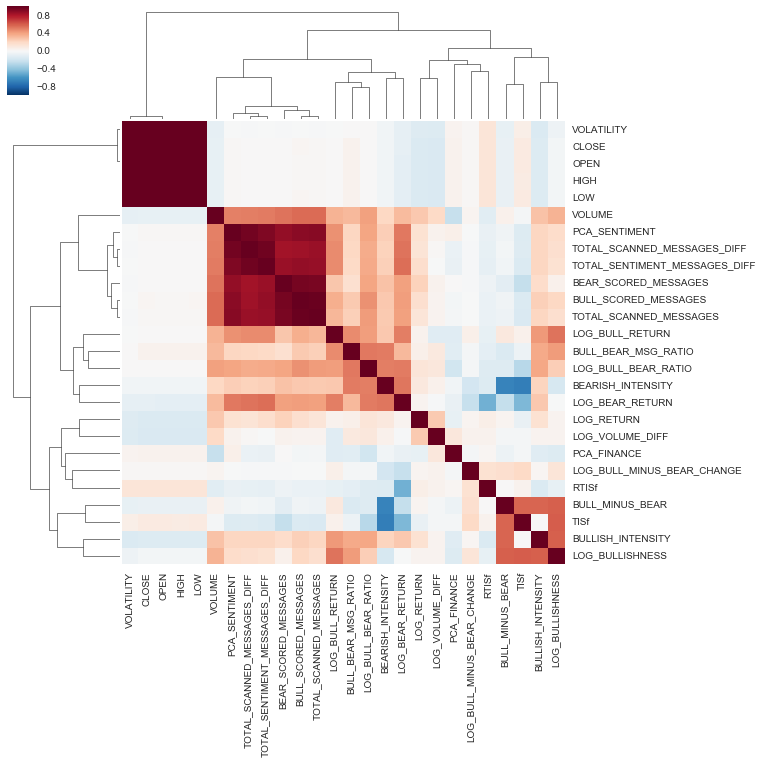

In [140]:
sentisignal.plot_clustermap(data_nasdaq_top_100_preprocessed_merge_window_30)

### PDF

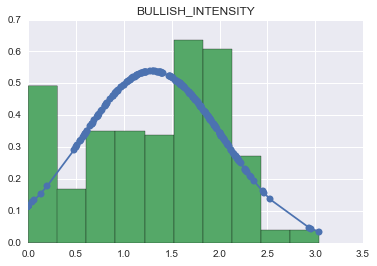

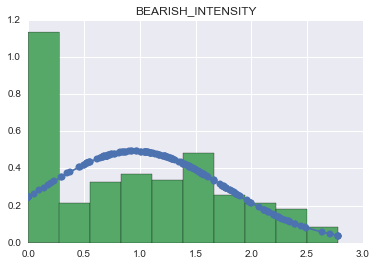

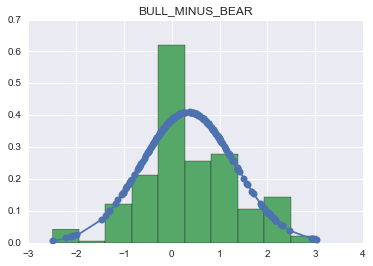

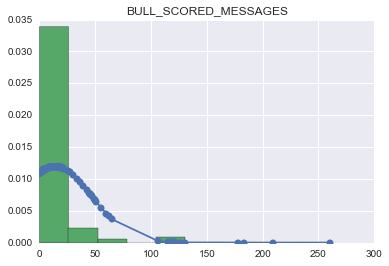

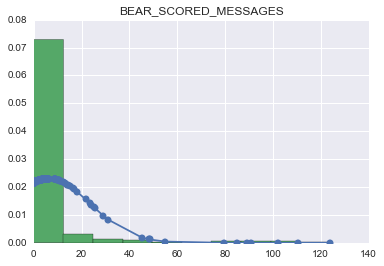

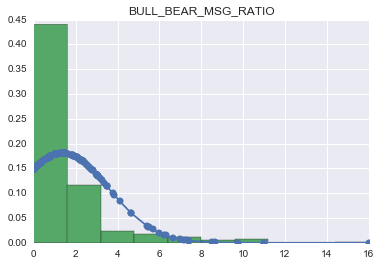

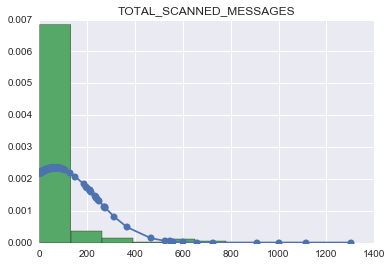

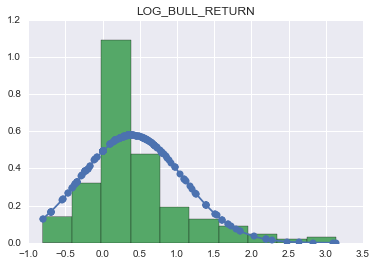

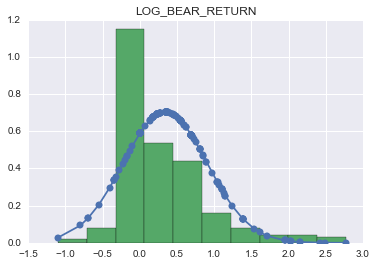

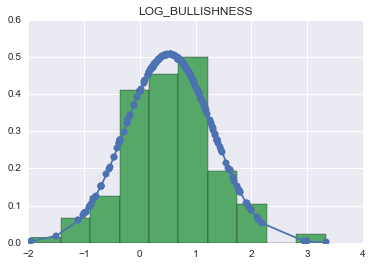

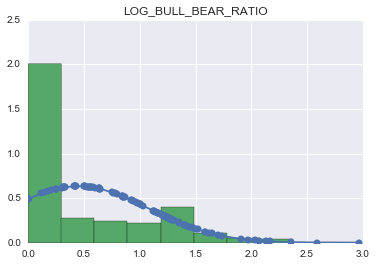

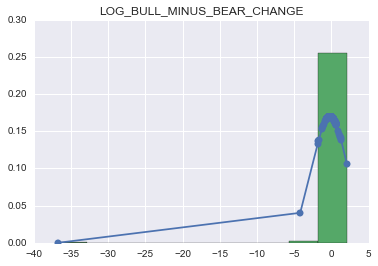

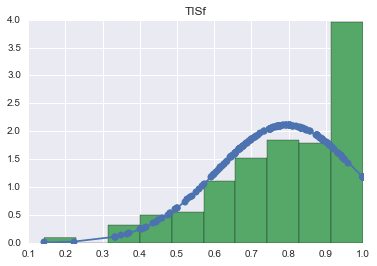

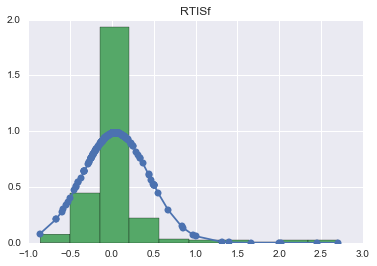

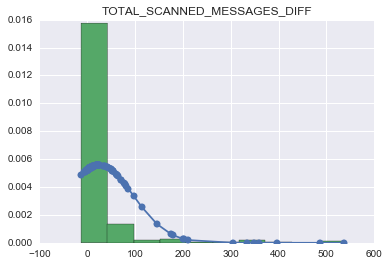

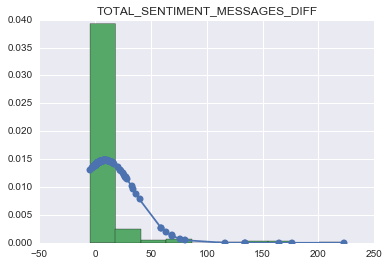

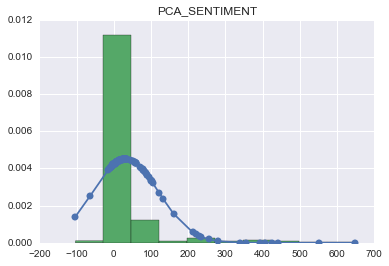

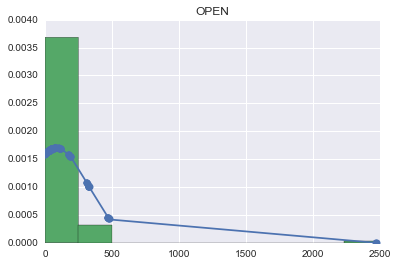

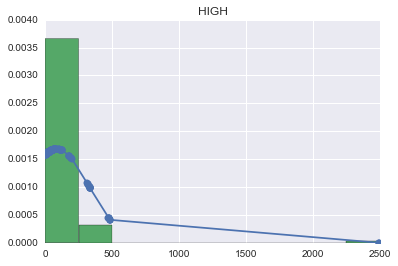

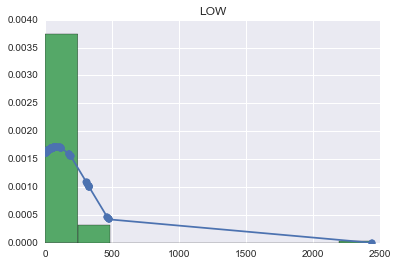

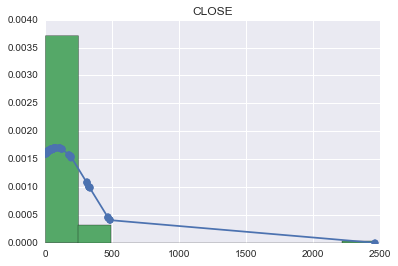

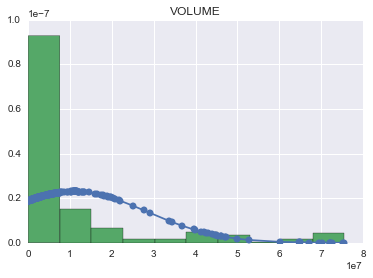

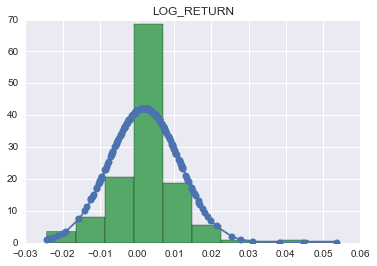

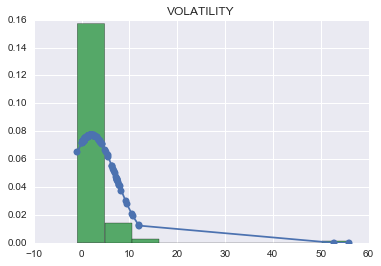

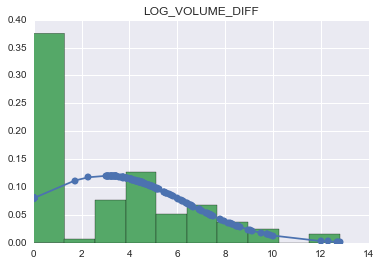

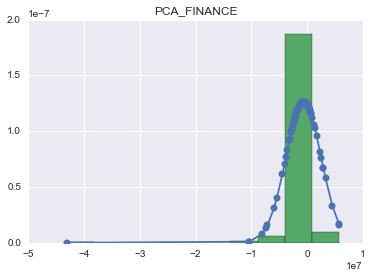

In [141]:
sentisignal.check_pdf(data_nasdaq_top_100_preprocessed_merge_window_30)

### ACF

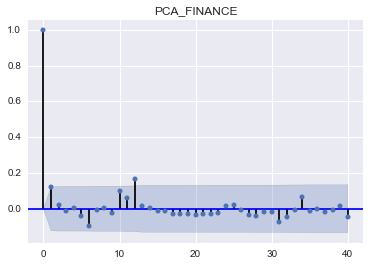

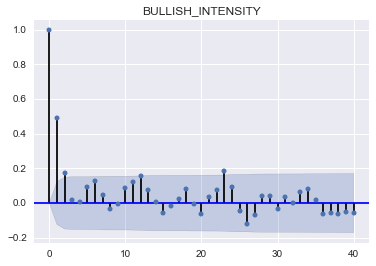

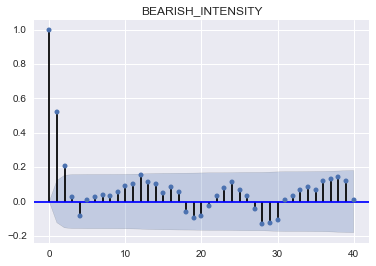

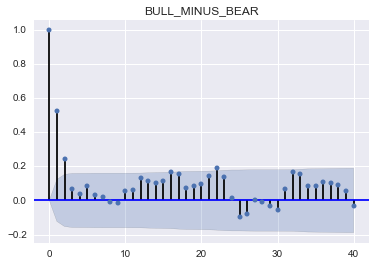

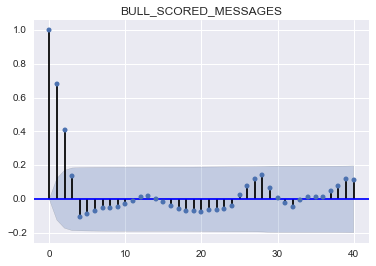

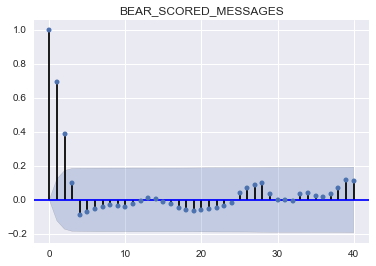

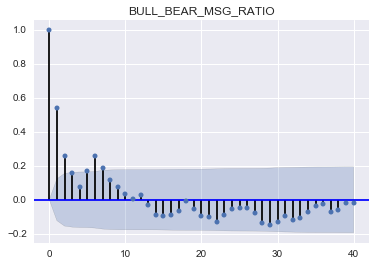

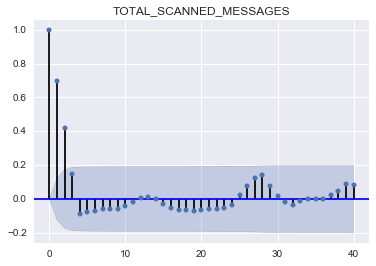

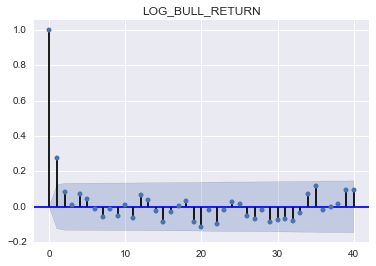

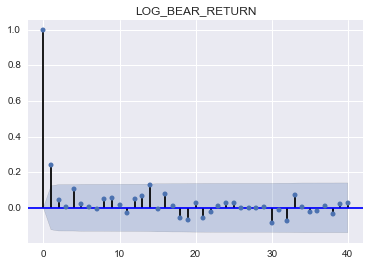

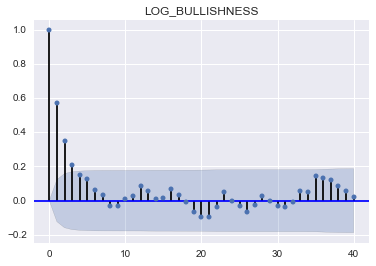

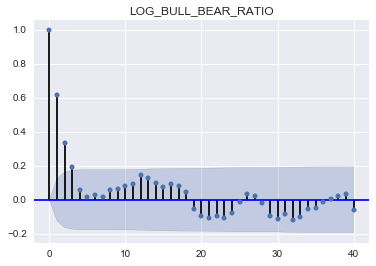

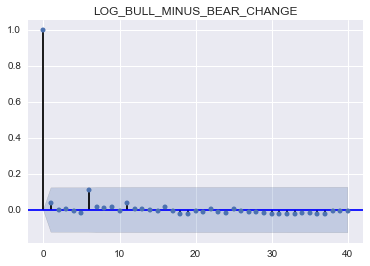

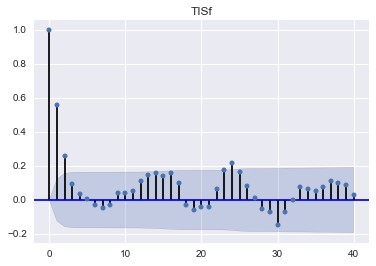

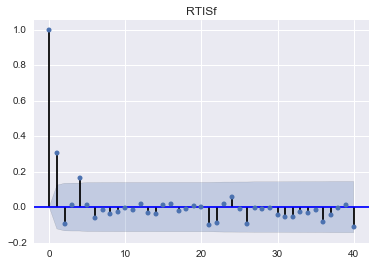

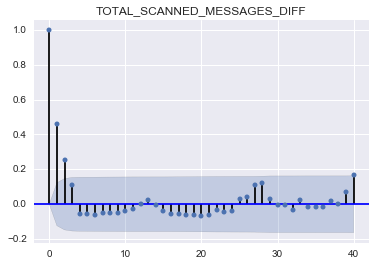

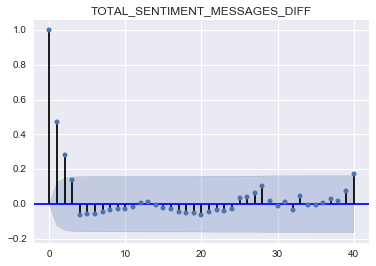

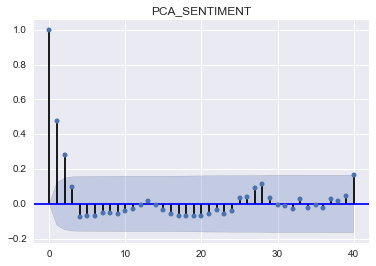

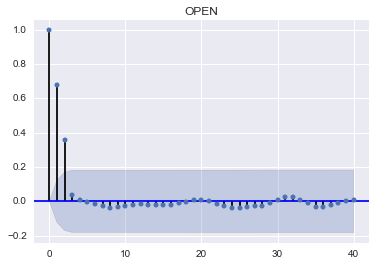

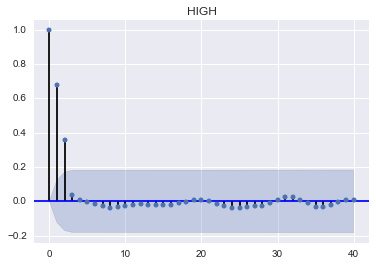

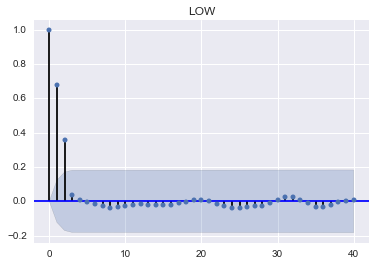

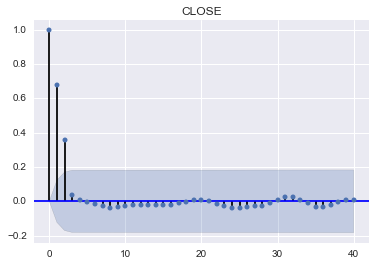

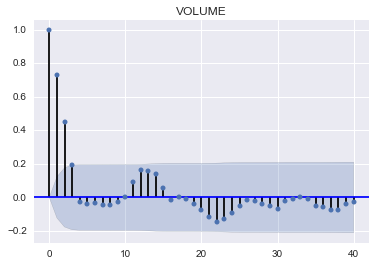

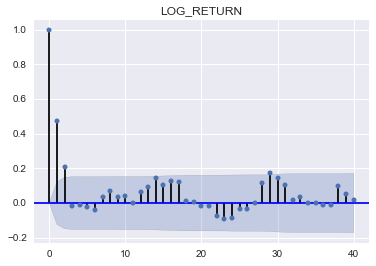

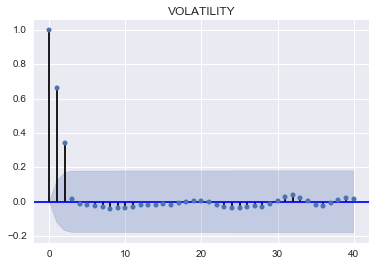

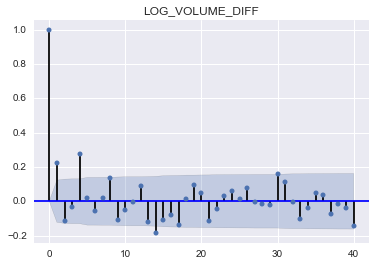

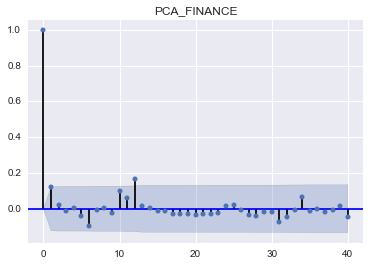

In [142]:
sentisignal.check_acf(data_nasdaq_top_100_preprocessed_merge_window_30)

### Regression plot PCA (Sentiment) and PCA (Finance)

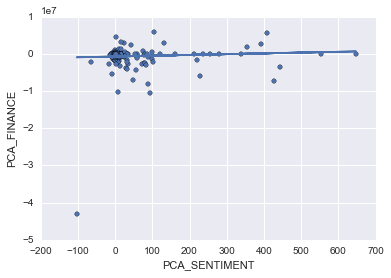

In [143]:
sentisignal.plot_scatter_regression(data_nasdaq_top_100_preprocessed_merge_window_30, 'PCA_SENTIMENT', 'PCA_FINANCE')

### Save results to intermediate pickle

In [144]:
data_nasdaq_top_100_preprocessed_merge_window_30.to_pickle(data_pickles_path+'intermediate/'+'data_nasdaq_top_100_preprocessed_merge_'+start_date+'_'+end_date+'_window_30')